In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Get path to data and create a data frame with summary analytics

path = 'archive/train.csv'

tr_data = pd.read_csv(path)
print(tr_data.info())
print(tr_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None
   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44   

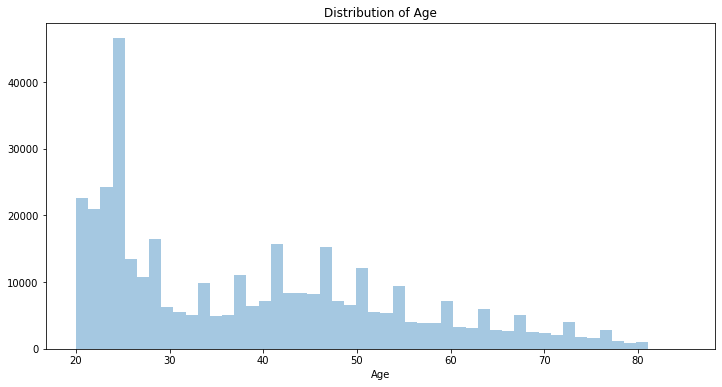

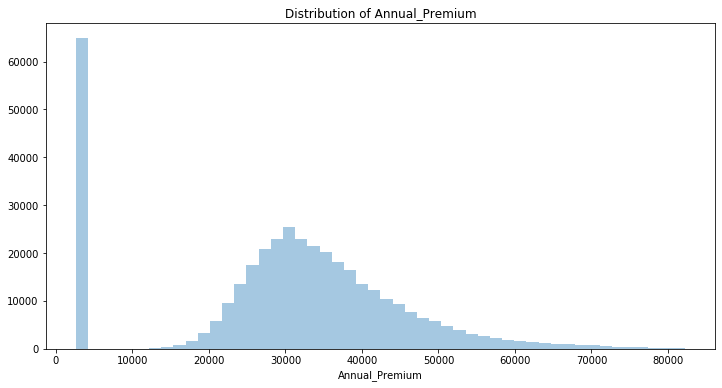

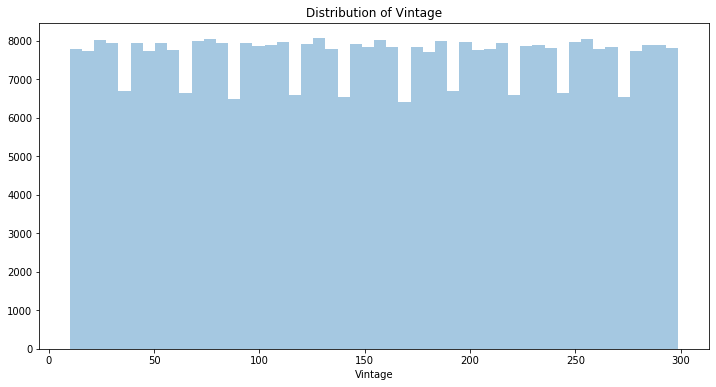

In [110]:
'''Based on our summary tables, we know that there is no missing data to worry about (nice!). First things first, we should
perform standard checks for normality on Age, Annual Premium, and Vintage'''

plt.figure(figsize=(12,6))
plt.title("Distribution of Age")
sns.distplot(a=tr_data['Age'], kde=False)

plt.figure(figsize=(12,6))
plt.title("Distribution of Annual_Premium")
sns.distplot(a=tr_data['Annual_Premium'], kde=False)
plt.show()

plt.figure(figsize=(12,6))
plt.title("Distribution of Vintage")
sns.distplot(a=tr_data['Vintage'], kde=False)
plt.show()

C:\Users\colin\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


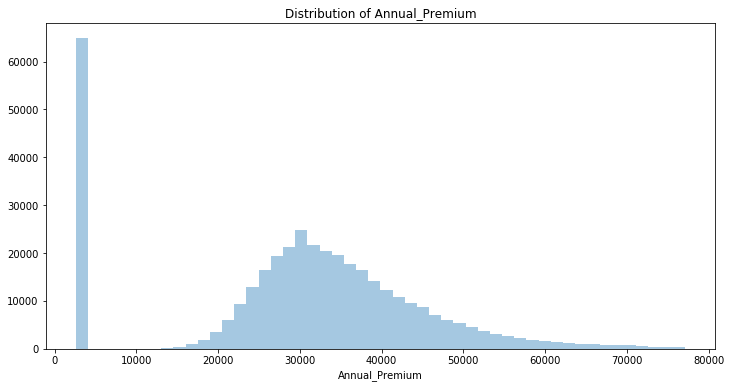

In [111]:
'''
Based on the results of our exploratory analysis on Age, Annual_Premium, and Vintage, we can conclude the following:
    1: Age is not normally distributed, and most likely will not be able to be standardized
    2: Annual Premium looks approximately normally distributed, but there are likely outliers that should be dealt with
    3: Vintage looks relatively uniform in the data set.
    
The first thing we should do is address 2, and find and remove outliers in the Annual_Premium attribute, replacing them
with the mean Annual_Premium. We will define outliers as those data points > 3 std away from the mean.
'''


def replace(group):
    mean, std = group.mean(), group.std()
    outliers = abs((group - mean)) > 3*std
    group[outliers] = mean       
    return group

plt.figure(figsize=(12,6))
plt.title("Distribution of Annual_Premium")
sns.distplot(a=tr_data['Annual_Premium'].transform(replace), kde=False)
plt.show()

In [7]:
'''
Based on what we get when we analyze Annual_Premium with outliers removed, there is a hidden "feature" in the data. Many
customers are paying a minimum premium. This could be a situation where we can introduce a new feature. We should see if
there is a clear impact of minimum payment on customer response.
'''

mode = tr_data['Annual_Premium'].mode()
print(tr_data[['Annual_Premium', 'Response']].loc[tr_data['Annual_Premium'] == int(mode)].groupby("Response").count())

#Conclusion: There is likely a significant relationship between minimum payment and response. This could be tested rigorously
#with a one-way ANOVA, but the effect is so clear here that we will skip that for now.

          Annual_Premium
Response                
0                  56372
1                   8505


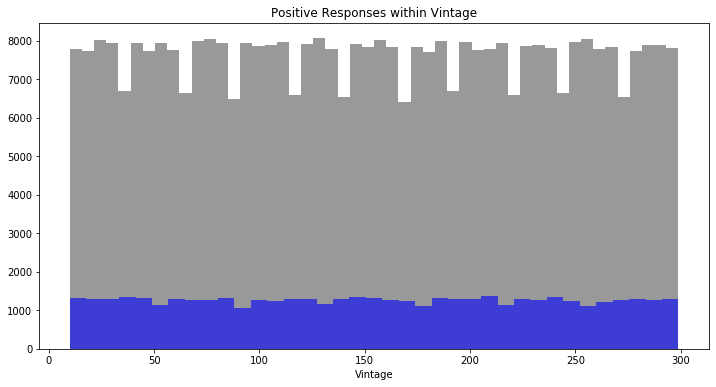

In [113]:
'''
We now turn our attention to vintage. We should see if there is a clear relationship between Vintage and Response. We can
visualize this relationship by comparing the proportion of each response within vintage.
'''

Series1 = tr_data['Vintage'].loc[tr_data['Response'] == 1]

plt.figure(figsize=(12,6))
plt.title('Positive Responses within Vintage')
bottom_plt = sns.distplot(a=tr_data['Vintage'], kde=False, color="black")
top_plt = sns.distplot(a=Series1, kde=False, color='blue', hist_kws=dict(alpha=.6))
plt.show()


#Conclusion: It seems that the proportion of negative responses is not affected by how long a customer has been with the 
#company. This may suggest that the customers income plays more into their response than their satisfaction with the company.
#This could explain what we observe in Annual_Premium. Customers who pay less on life insurance may be poorer, meaning their
#response may not reflect desire, but rather ability to pay. 

     Response
Age          
20   0.027439
21   0.034879
22   0.036396
23   0.036774
24   0.035169
..        ...
81   0.071429
82   0.034483
83   0.045455
84   0.000000
85   0.000000

[66 rows x 1 columns]


Text(0.5, 0, 'Age')

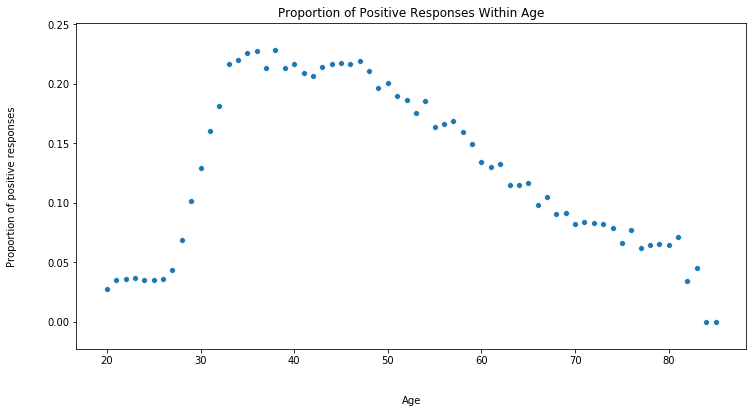

In [124]:
'''
Now we must turn our attention to Age. We can visualize the relationship between age and response similarly to vintage.
However, Vintage was approximately uniform whereas age is not, so we should visualize response as a proportion in this case.
'''

#Get all the responses from Age that were positive and group by age, then the total number of responses grouped by age
age_pos = tr_data[['Age','Response']].loc[tr_data['Response'] == 1].groupby('Age').count()
age_tot = tr_data[['Age','Response']].groupby('Age').count()

#Divide the number of positive responses by the total number of responses to get a percentage
age_pos_adj = age_pos/age_tot
age_pos_adj = age_pos_adj.fillna(0)
print(age_pos_adj)


plt.figure(figsize=(12,6))
plt.title('Proportion of Positive Responses Within Age')
bottom_plt = sns.scatterplot(x=age_pos_adj.index, y=age_pos_adj['Response'])
plt.ylabel('Proportion of positive responses', labelpad=30)
plt.xlabel('Age', labelpad=30)

#Conclusion: The probability that a customer will respond positively is uniformly distributed around age. This is a pretty
#nice result, since if we choose to include response percentage as a feature in a linear regression model this feature is
#likely to play well.